In [2]:
""" Import libraries """
import pandas as pd
import numpy as np
from src.features.DataProcessor import DataProcessor
from src.models.RandomForestClassifier import RFClassifier
from scipy.stats import randint as sp_randint

In this notebook we will train and save a random forest model then plot and show differents metrics for the model

In [3]:
withOutliers = True
dict = {True: 'without', False: 'with'}

df_train = pd.read_csv(f'../data/interim/train_{dict[withOutliers]}_outliers.csv')
df_test = pd.read_csv(f'../data/interim/test_{dict[withOutliers]}_outliers.csv')

processor = DataProcessor()

# Encode the labels
df_train = processor.encode_labels(df_train,fit=True)
df_test = processor.encode_labels(df_test,fit=False)


In [4]:
df_train_processed = processor.remove_correlation(df_train,fit=True)
df_train_processed = processor.scale_data(df_train_processed,fit=True)

df_test_processed = processor.remove_correlation(df_test,fit=False)
df_test_processed = processor.scale_data(df_test_processed,fit=False)

# Split the origin training data
X_train,y_train = processor.split_data(df_train)
# Split the processed training data
X_test,y_test = processor.split_data(df_test_processed)

We do a grid search to find the best parameters for the model

We run this code in google colab and save the data of the grid searh in a csv file

 [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1TqehMW7PY5Uu6mqdNrI-QY-2_uj9qFE5?authuser=2#scrollTo=yZtNVPu0hrp-)

In [6]:
#random search for random forest

clf = RFClassifier()
param_dist = {
    'bootstrap': [True],
    'random_state': [0],
    'max_depth': sp_randint(10, 100),
    'max_features': sp_randint(1, 8),
    'min_samples_leaf': sp_randint(1, 10),
    'min_samples_split': sp_randint(5, 20),
    'n_estimators': sp_randint(100, 700),
    'class_weight': [None,'balanced', 'balanced_subsample'],
    'criterion': ['gini'],
    'warm_start': [False],
    'ccp_alpha': [0],
}
clf.hyperparameter_tuning(X_train,y_train,param_dist,'halving-random',3,'f1_macro')
print(clf.best_params)

{'model__bootstrap': True, 'model__ccp_alpha': 0, 'model__class_weight': 'balanced', 'model__criterion': 'gini', 'model__max_depth': 33, 'model__max_features': 5, 'model__min_samples_leaf': 6, 'model__min_samples_split': 18, 'model__n_estimators': 164, 'model__random_state': 0, 'model__warm_start': False}


In [5]:
clf = RFClassifier()
clf.load(new_name="RF_withoutoutliers")

Show results of the model, plot the confusion matrix and show the classification report

Inference time : 2.2539782027403513e-05 seconds
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     11571
           1       0.96      0.93      0.95      3711
           2       1.00      1.00      1.00      3918

    accuracy                           0.98     19200
   macro avg       0.98      0.97      0.98     19200
weighted avg       0.98      0.98      0.98     19200

auc score for class 0:  0.9948706974291601
auc score for class 1:  0.9924006969489164
auc score for class 2:  0.999906663689792


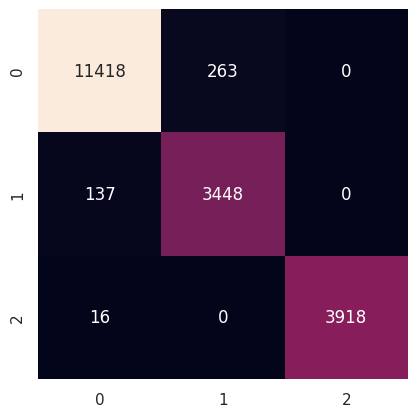

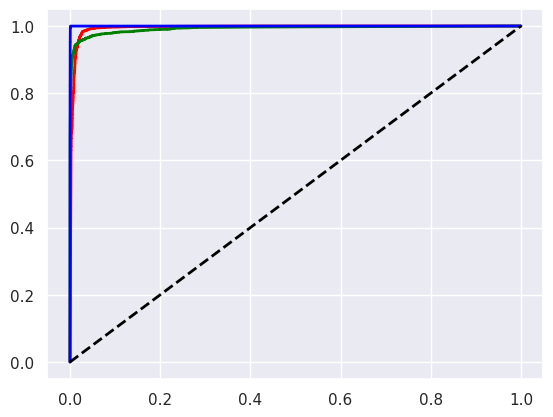

In [6]:
clf.evaluate(X_test, y_test)

Save the model to be used for comparison

In [ ]:
clf.save('RandomForest_scaled_cut')